# PYMC3 Intro

Code taken from https://docs.pymc.io/pymc-examples/examples/pymc3_howto/api_quickstart.html

In [2]:
import pymc3 as pm

import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import theano.tensor as tt

In [3]:
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


In [4]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

In [5]:
model.basic_RVs

[mu ~ Normal, obs ~ Normal]

In [9]:
vars(model)

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7fa4f2669b20>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'mu': mu ~ Normal, 'obs': obs ~ Normal},
 'free_RVs': [mu ~ Normal],
 'observed_RVs': [obs ~ Normal],
 'deterministics': [],
 'potentials': [],
 'missing_values': [],
 'mu': mu ~ Normal,
 'obs': obs ~ Normal}

In [17]:
model.logp({"mu": 0})

array(-133.55535502)

In [25]:
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)

In [26]:
x.logp({"x": 0})

array(-0.91893853)

## Sampling

In [28]:
import multiprocessing
multiprocessing.cpu_count()

8

In [38]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))
    
    idata = pm.sample(2000, tune=1500, return_inferencedata=True, cores=8, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 2 seconds.


In [39]:
idata.posterior["mu"].shape

(4, 2000)

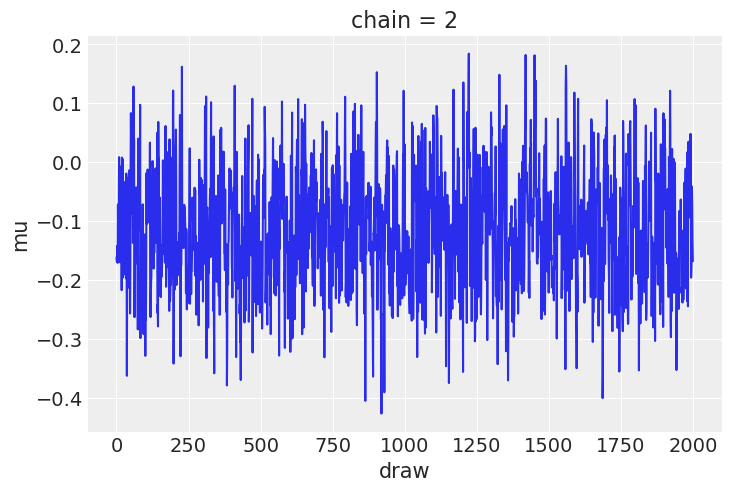

In [40]:
idata.posterior["mu"].sel(chain=2).plot()

In [41]:
idata.posterior["mu"].sel(chain=2)

<xarray.DataArray 'mu' (draw: 2000)>
array([-0.16161849, -0.16881667, -0.16803402, ..., -0.07135871,
       -0.13601778, -0.16841328])
Coordinates:
    chain    int64 2
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

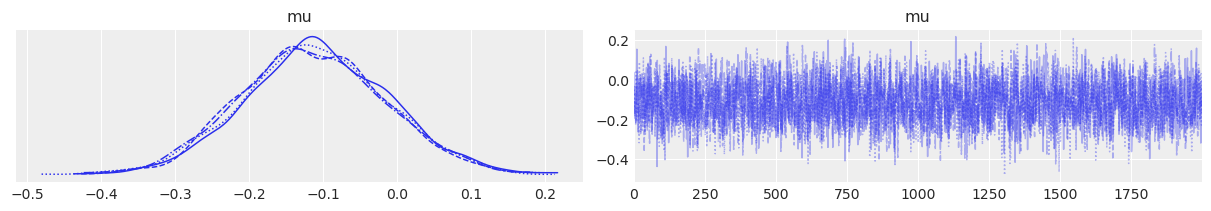

In [44]:
az.plot_trace(idata)

In [45]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.112,0.098,-0.301,0.069,0.002,0.001,3353.0,5284.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

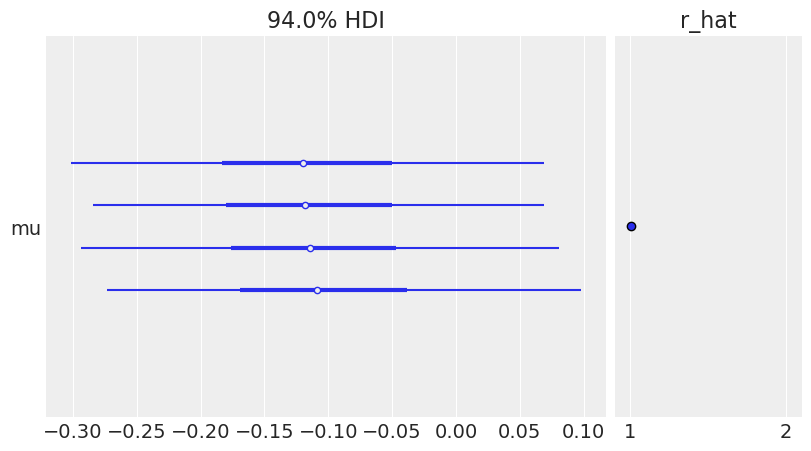

In [46]:
az.plot_forest(idata, r_hat=True)

<AxesSubplot:title={'center':'mu'}>

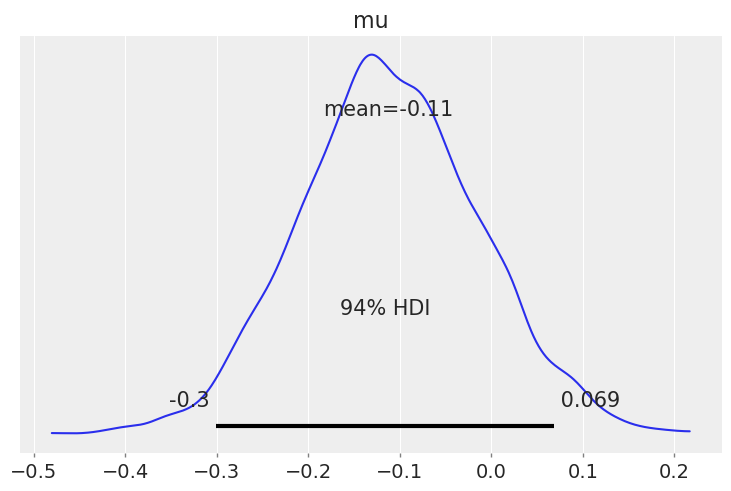

In [48]:
az.plot_posterior(idata)

## Posterior predictive sampling

In [49]:
data = np.random.randn(100)
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=data)

    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [52]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)
# add posterior predictive to the InferenceData
az.concat(idata, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

/root/miniconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


TypeError: Concatenating overlapping groups is not supported unless `dim` is defined. Valid dimensions are `chain` and `draw`. Alternatively, use extend to combine InferenceData with overlapping groups

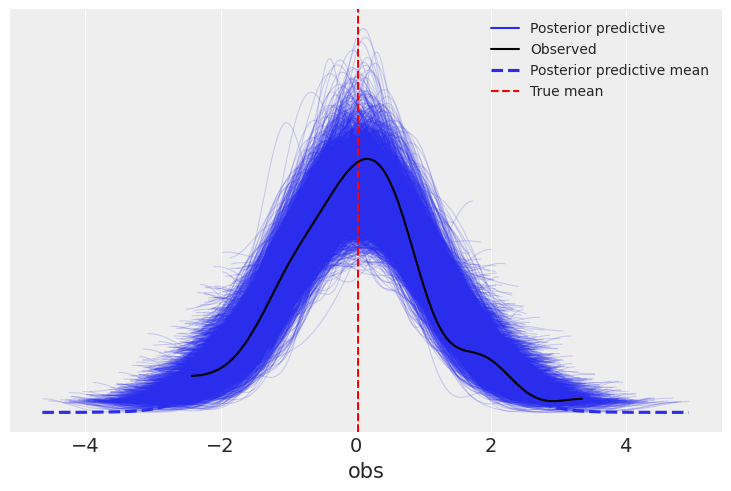

In [53]:
fig, ax = plt.subplots()
az.plot_ppc(idata, ax=ax)
ax.axvline(data.mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);